# CS345 Project Final Report: Machine Learning Analysis on Windows Portable Executable File Analysis
*Author: Tyler Rios*

*GitHub: [https://github.com/rios240/CS345-Project-Report](https://github.com/rios240/CS345-Project-Report)*

### Introduction
In the ever-evolving landscape of cybersecurity, the detection and analysis of malware are critical tasks for safeguarding digital systems. Windows Portable Executable (PE) files, being a fundamental component of Windows operating systems, are often targeted by malicious actors to execute and propagate malware. This project aims to leverage machine learning techniques to analyze a curated dataset of Windows PE malware, comparing predictive models for malware detection.

The data set employed in this report is the SOMLAP PE Malware data set which comprises a diverse collection of Windows PE sample files.

More information on SOMLAP data set can be found here:
- [https://www.kaggle.com/datasets/ravikiranvarmap/somlap-data-set](https://www.kaggle.com/datasets/ravikiranvarmap/somlap-data-set)
- Kattamuri, Santosh Jhansi, Ravi Kiran Varma Penmatsa, Sujata Chakravarty, and Venkata Sai Pavan Madabathula. 2023. "Swarm Optimization and Machine Learning Applied to PE Malware Detection towards Cyber Threat Intelligence" Electronics 12, no. 2: 342.
https://doi.org/10.3390/electronics12020342

### About the Data Set

We'll begin by importing and showing general information about the data set that could influence preprocessing and classifier configurations.

In [1]:
import pandas as pd
import numpy as np

url = 'https://raw.githubusercontent.com/rios240/CS345-Project-Report/main/SOMLAP%20DATASET.csv'

somlap = pd.read_csv(url)

somlap.head()

,blp,Fp,Rn,Prhdr,Minpar,Maxpar,Ivalss,Ivalsp,doscksum,Iip,...,bss_viraddr,bss_datsize,bss_ptrrawdat,bss_char,bss_entro,bss_phyaddr.1,bss_virsize.1,bss_viraddr.1,bss_char.1,class
0,144,3,0,4,0,65535,0,184,0,0,...,0,0,0,0,0.0,0,0,0,0,0
1,144,3,0,4,0,65535,0,184,0,0,...,0,0,0,0,0.0,0,0,0,0,0
2,144,3,0,4,0,65535,0,184,0,0,...,0,0,0,0,0.0,0,0,0,0,0
3,144,3,0,4,0,65535,0,184,0,0,...,0,0,0,0,0.0,0,0,0,0,0
4,144,3,0,4,0,65535,0,184,0,0,...,0,0,0,0,0.0,0,0,0,0,0


In [2]:
somlap.tail()

,blp,Fp,Rn,Prhdr,Minpar,Maxpar,Ivalss,Ivalsp,doscksum,Iip,...,bss_viraddr,bss_datsize,bss_ptrrawdat,bss_char,bss_entro,bss_phyaddr.1,bss_virsize.1,bss_viraddr.1,bss_char.1,class
51403,144,3,0,4,0,65535,0,184,0,0,...,0,0,0,0,0.0,0,0,0,0,1
51404,144,3,0,4,0,65535,0,184,0,0,...,0,0,0,0,0.0,0,0,0,0,1
51405,144,3,0,4,0,65535,0,184,0,0,...,0,0,0,0,0.0,0,0,0,0,1
51406,144,3,0,4,0,65535,0,184,0,0,...,0,0,0,0,0.0,0,0,0,0,1
51407,144,3,0,4,0,65535,0,184,0,0,...,0,0,0,0,0.0,0,0,0,0,1


In [3]:
print(somlap.columns)
print(np.unique(somlap['class']))

Index(['blp', 'Fp', 'Rn', 'Prhdr', 'Minpar', 'Maxpar', 'Ivalss', 'Ivalsp',
       'doscksum', 'Iip',
       ...
       'bss_viraddr', 'bss_datsize', 'bss_ptrrawdat', 'bss_char', 'bss_entro',
       'bss_phyaddr.1', 'bss_virsize.1', 'bss_viraddr.1', 'bss_char.1',
       'class'],
      dtype='object', length=109)
[0 1]


SOMLAP contains 51,408 samples, 108 features, and no NaN values. Now we will examine the ratio of benign to malware samples to see if the data set is balanced.

In [4]:
somlap['class'].value_counts()

class
0    31600
1    19808
Name: count, dtype: int64

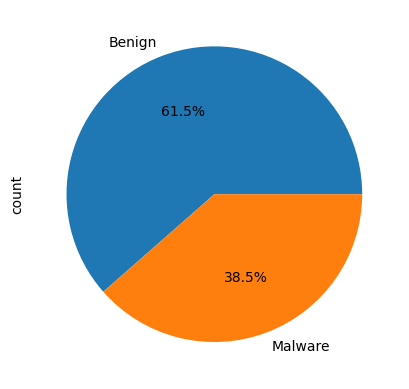

In [2]:
import matplotlib.pyplot as plt

somlap['class'].value_counts().plot(kind="pie",autopct="%1.1f%%", labels=['Benign', 'Malware'])
plt.show()

This quick data set analysis reveals three key findings:
1. Some of the features' values are significantly larger than others meaning that the data set could benefit from standardization.
2. The data set contains 108 features meaning it has a high dimensional space and could benefit from dimensionality reduction using PCA.
3. The ratio of benign to malware samples suggest the data set is imbalanced and thus classifiers could be biased toward the majority class.
4. Cross validation with Grid Search could be used to find optimal hyperparameters.

### Baseline
We wish to take a baseline performance that we can compare to later on. The baseline will be the best performing SVC kernel (except linear which we will see why later) using default hyperparameters and standard train/test splits. 

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.utils import parallel_backend

somlap_X = somlap.drop('class', axis=1).values
somlap_y = somlap['class'].values

In [36]:
def take_baseline(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    for kernel in ['poly', 'rbf', 'sigmoid']:
        classifier = SVC(kernel=kernel)
        with parallel_backend('threading'):
            classifier.fit(X_train, y_train)
            y_pred = classifier.predict(X_test)

            accuracy = balanced_accuracy_score(y_test, y_pred)

            print(f'{kernel} kernel accuracy: {accuracy:.4f}')

In [34]:
take_baseline(somlap_X, somlap_y)

poly kernel accuracy: 0.8965
rbf kernel accuracy: 0.9024
sigmoid kernel accuracy: 0.8454


### Standardization and PCA
A Gaussian kernel performs the best. Now that we have a baseline we can see how standardizing and reducing the dimensional space of SOMLAP can imporve performance.

In [4]:
def plot_components_accuracy(results):
    plt.plot(list(results.keys()), list(results.values()), marker='o')
    plt.title('Accuracies over n_components')
    plt.xlabel('n_components')
    plt.ylabel('Accuracy')
    plt.show()


def compute_new_gaussian_svc(X, y, test_size=0.2, random_state=42):
    X = StandardScaler().fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    classifier = SVC(kernel='rbf')
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print(f'Accuracy after standardization: {balanced_accuracy_score(y_test, y_pred)}')
    
    n_components_list = [2, 10, 25, 50, 75, 108]
    results = {}
    for n_components in n_components_list:
        x = PCA(n_components=n_components).fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)
        classifier = SVC(kernel='rbf')
        with parallel_backend('threading'):
            classifier.fit(X_train, y_train)
            y_pred = classifier.predict(X_test)
             
            accuracy = balanced_accuracy_score(y_test, y_pred)
            results[n_components] = accuracy
    
    print(results)
    plot_components_accuracy(results)
    

Accuracy after standardization: 0.9615306871265678
{2: 0.8522921050125881, 10: 0.9232654726024916, 25: 0.9522094077116395, 50: 0.9598712509301242, 75: 0.9608939066884628, 108: 0.9615306871265678}


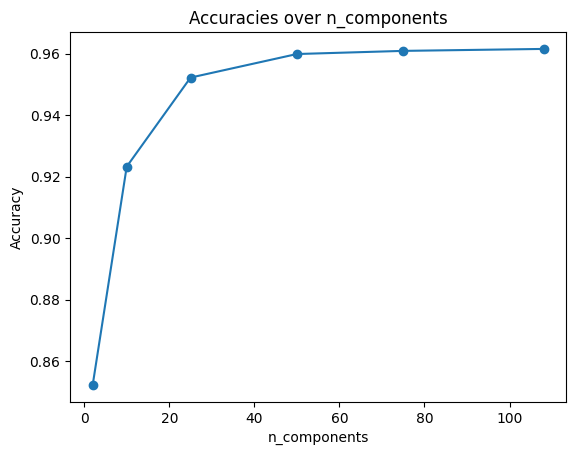

In [5]:
compute_new_gaussian_svc(somlap_X, somlap_y)

### Grid Search and Cross Validation
Standardizing SOMLAP resulted in a boost in accuracy. With PCA the accuracy plateaus around 50 components so this will be used going forward.

Although accuracy has become quite high we have been using default hyperparameters which may not be the most optimal. Additionally, we have been using generic train/test split with a relatively low test_size. Since SOMLAP is so large we could simply increase the test_size to be 0.5, however, we will use cross validation with StratifiedKFold.

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

def nested_cross_validation(X, y, n_components=50, random_state=42, n_splits=5, n_jobs=1):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n_components)),
        ('svc', SVC(kernel='rbf'))
    ])

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    param_grid = {
        'svc__C': [1, 10, 100],
        'svc__gamma': [0.001, 0.01, 0.1]
    }

    classifier = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='balanced_accuracy', cv=cv, n_jobs=n_jobs)
    classifier.fit(X, y)
    accuracies = cross_val_score(classifier, X, y, cv=cv, scoring='balanced_accuracy', n_jobs=n_jobs)
    return np.mean(accuracies), classifier.best_params_

In [6]:
accuracy, best_params = nested_cross_validation(somlap_X, somlap_y, n_jobs=2)
print(f'Nested cross validation accuracy {accuracy} with hyperparameters {best_params}')

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'